# Creating Saliency Maps for CNNs

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**Explainable AI (XAI), or Interpretable AI, or Explainable Machine Learning (XML), is AI in which the results of the solution can be understood by humans. It contrasts with the concept of the "[black box](https://en.wikipedia.org/wiki/Black_box "Black box")" in machine learning where even its designers cannot explain why an AI arrived at a specific decision.**

**One of the main ideas behind Explainable AI (XAI) is the moto that
"_complex systems (like neural networks) need to be interpretable to humans._" As a response to the concerns raised against model opacity, the field of interpretability (specifically in CV applications) has formed two major threads of response: feature visualization and saliency mapping. This notebook focuses on saliency mapping techniques.**

![image](https://raw.githubusercontent.com/jacobgil/keras-cam/master/examples/dog.jpg)

**For a comprehensive explanation of the limitations and difficulties related to saliency mapping techniques, [we recommend this article](https://arxiv.org/abs/2002.00772), made by _[Ahmed Alqaraawi](https://arxiv.org/search/cs?searchtype=author&query=Alqaraawi%2C+A), [Martin Schuessler](https://arxiv.org/search/cs?searchtype=author&query=Schuessler%2C+M), [Philipp Weiß](https://arxiv.org/search/cs?searchtype=author&query=Wei%C3%9F%2C+P), [Enrico Costanza](https://arxiv.org/search/cs?searchtype=author&query=Costanza%2C+E), [Nadia Berthouze](https://arxiv.org/search/cs?searchtype=author&query=Berthouze%2C+N)_.**

**For a complete guide on ML Explainability, we recommend "_[Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)_" (by _Christoph Molnar_).**

**In this notebook, we will be interpreting a CNN trained on the ***CIFAR-10 dataset***. The CIFAR-10 dataset ([Canadian Institute For Advanced Research](https://en.wikipedia.org/wiki/Canadian_Institute_for_Advanced_Research "Canadian Institute for Advanced Research")) is a collection of images that are commonly used to train [machine learning](https://en.wikipedia.org/wiki/Machine_learning "Machine learning") and [computer vision](https://en.wikipedia.org/wiki/Computer_vision "Computer vision") algorithms. It is one of the most widely used datasets for machine learning research, containing 60,000 32x32 color images in 10 different classes. The ten classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks (there are 6,000 images of each class).**


In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import cm
import plotly.express as px
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import datasets, models
from keras.models import Sequential
from keras.preprocessing import image


**Convolutional layers are the de-facto standard in image classification. However, the training of a CNN (*Convolutional neural network*) is outside the scope of this notebook. So, we are just gonna upload a pre-trained model. You can find loads of tutorials on how to train a CNN in the literature, like in [_Deep Learning with Python_](https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf), and in this [notebook](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/bbe9c0a77499fa68de7c6d53bf5ef7e0b43a25e0/ML%20Explainability/CV%20Interpreter/CNN_model_maker.ipynb).**

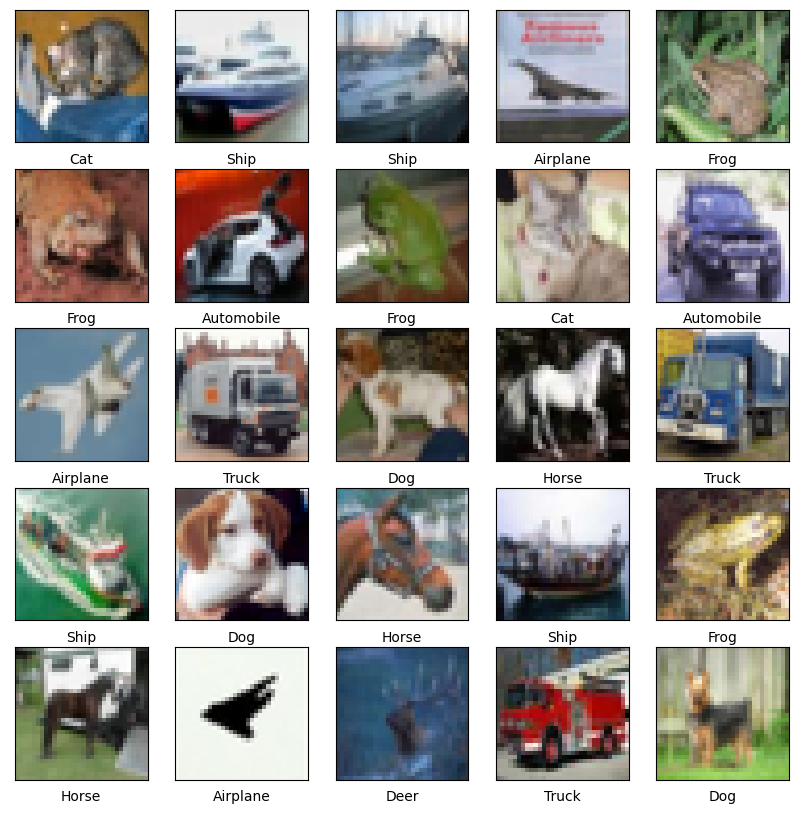

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [2]:
(_, _), (x_test, y_test) = datasets.cifar10.load_data()

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i][0]])

plt.show()

model = tf.keras.models.load_model('models\pre_trained_Cifar_CNN.h5')
x_test = x_test.astype('float32')
x_test = x_test / 255.
y_test = np_utils.to_categorical(y_test, 10)
test_loss_score, test_acc_score = model.evaluate(x_test, y_test, verbose=0)
model.summary()
print(f'Loss: {round(test_loss_score, 2)}.')
print(f'Accuracy: {round(test_acc_score * 100, 2)} %.')

**Now let's write a function to return labels, predictions and images (feel free to write a better one).** 🙃

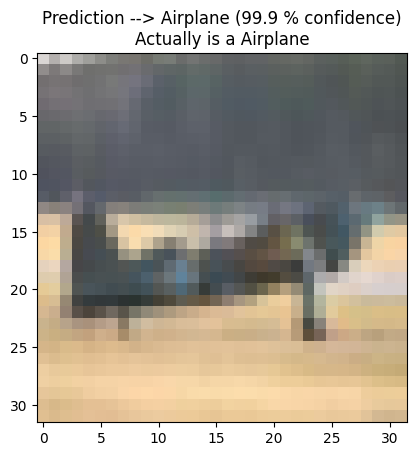

In [5]:
def predict_image(x_test, y_test, sample):
    img_tensor = np.expand_dims(x_test[sample], axis=0)
    pred = [round(num, 3) for num in list(model.predict(img_tensor, verbose=0)[0])]
    plt.figure()
    plt.imshow(x_test[sample])
    plt.title(
        f'Prediction --> {class_names[np.array(pred).argmax()]} ({round(max(pred) * 100, 2)} % confidence)\nActually is a {class_names[y_test[sample].argmax()]}')
    return plt.show()

predict_image(x_test, y_test, np.random.randint(0, 9999))

## Saliency Maps with `Grad-Cam`

**Saliency maps (also known as _Class Activation Maps_ - CAM) are a simple technique to get the discriminative image regions used by a `CNN` to identify a specific class in the image. In other words, a saliency map lets us see which regions in the image were relevant to this class.**

**The main intutition behind this techenique is:**

- _“how intensely the input image activates different channels” by “how important each channel is with regard to the class” is equal to how intensely the input image activates the class.”_

**The techenique we are using in this notebook is [Grad-Cam](https://arxiv.org/abs/1610.02391), proposed by _[Ramprasaath R. Selvaraju](https://arxiv.org/search/cs?searchtype=author&query=Selvaraju%2C+R+R), [Michael Cogswell](https://arxiv.org/search/cs?searchtype=author&query=Cogswell%2C+M), [Abhishek Das](https://arxiv.org/search/cs?searchtype=author&query=Das%2C+A), [Ramakrishna Vedantam](https://arxiv.org/search/cs?searchtype=author&query=Vedantam%2C+R), [Devi Parikh](https://arxiv.org/search/cs?searchtype=author&query=Parikh%2C+D), [Dhruv Batra](https://arxiv.org/search/cs?searchtype=author&query=Batra%2C+D)_.**

**Saliency maps are the product of a convolutional layer, so we have to choose which layer should produce our map.**

In [6]:
for layer in model.layers:
    print(layer.name)

conv2d
batch_normalization
conv2d_1
batch_normalization_1
max_pooling2d
dropout
conv2d_2
batch_normalization_2
conv2d_3
batch_normalization_3
max_pooling2d_1
dropout_1
conv2d_4
batch_normalization_4
conv2d_5
batch_normalization_5
max_pooling2d_2
dropout_2
flatten
dense
batch_normalization_6
dropout_3
dense_1


**We will use the last normalization layer before the head (the dense part of our network) of the model, i.e., `batch_normalization_5`.**

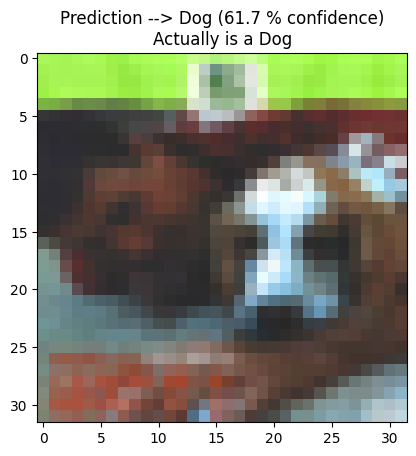

In [7]:
sample = np.random.randint(0, 9999)
predict_image(x_test, y_test, sample)
last_conv_layer_name = 'batch_normalization_5'


**Bellow we create two functions: one to generate the array of values that represent our saliency map (`create_saliency_map`), and another to generate this map as a plotly heatmap (`create_saliency_map`).**

In [8]:
def make_gradcam_map(image, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    img_array = np.expand_dims(image, axis=0)
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = np.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def create_saliency_map(heatmap):
    saliency_map = np.maximum(heatmap, 0)
    saliency_map /= np.max(saliency_map)


    fig = px.imshow(saliency_map,
                    title=f'Saliency Map',
                    text_auto=True)
    fig.update_layout({
        'template': 'plotly_dark',
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'title_x': 0.5,
    })

    return fig.show()

model.layers[-1].activation = None
create_saliency_map(make_gradcam_map(x_test[sample], model, last_conv_layer_name))

**With this saliency map, we can combine the original image with the map to generate an "_attention map_", i.e. _which areas of the image does the model assign more weight to generate its classification_.  We are doing this by creating a function called `display_gradcam`.**

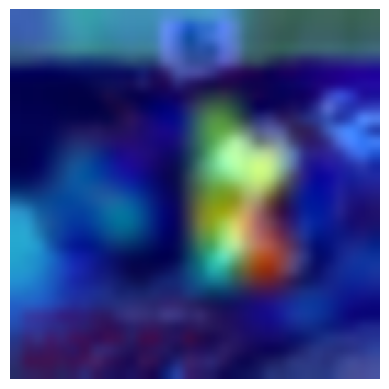

In [9]:
def display_gradcam(img, heatmap, alpha):
    imge = np.expand_dims(img, axis=0)[0]

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap('jet')

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((imge.shape[1], imge.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + imge
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    superimposed_img = superimposed_img.resize((150, 150))
    plt.figure()
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

saliency_map = make_gradcam_map(x_test[sample], model, last_conv_layer_name)
display_gradcam(x_test[sample], saliency_map, 0.005)

**Other Grad-CAM examples can be loaded from the `Saliency Map` folder.**

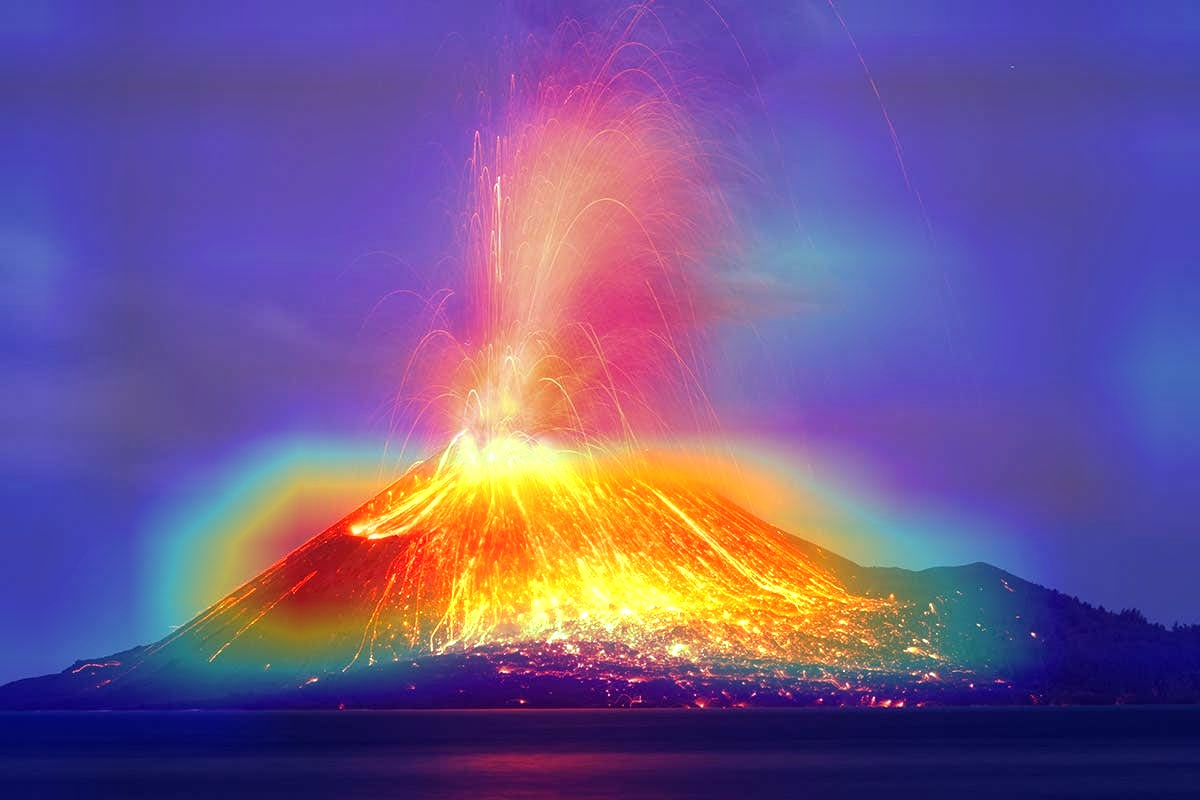

In [29]:
from IPython.display import Image
display(Image(filename=r'Saliency Map\volcano_CAM.jpg'))

**You can use these functions to create Saliency Maps for any Keras-based model. You can also load some of the many models that come with TensorFlow to explore the type of maps that their classifications generate (e.g., VGG16, MobileNetV2, etc.)** 🙃

----

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).
